# IMPORTS

In [3]:
import json
from torchvision.transforms.functional import to_pil_image
from PIL import Image, ImageEnhance
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import os
import numpy as np
import open_clip
from pathlib import Path
from itertools import combinations
from scipy.stats import wilcoxon, rankdata

/home/antonello03/anaconda3/envs/py31/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
root = Path("synth_out")
top4styles = ["Impressionism", "Realism", "Baroque", "Romanticism"]

rmse_imgs, prs_imgs, cos_imgs = [], [], []

for style in top4styles:
    for i in range(3):
        rmse_imgs.append(Image.open(root / f"RMSE_{style}_{i}.jpg"))
        prs_imgs.append(Image.open(root / f"PRS_{style}_{i}.jpg"))
        cos_imgs.append(Image.open(root / f"COS_{style}_{i}.jpg"))

In [3]:
!pip install open-clip-torch


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import os
import torch
import torch.nn as nn
from os.path import expanduser  # pylint: disable=import-outside-toplevel
from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel
def get_aesthetic_model(clip_model="vit_l_14"):
    """load the aethetic model"""
    home = expanduser("~")
    cache_folder = home + "/.cache/emb_reader"
    path_to_model = cache_folder + "/sa_0_4_"+clip_model+"_linear.pth"
    if not os.path.exists(path_to_model):
        os.makedirs(cache_folder, exist_ok=True)
        url_model = (
            "https://github.com/LAION-AI/aesthetic-predictor/blob/main/sa_0_4_"+clip_model+"_linear.pth?raw=true"
        )
        urlretrieve(url_model, path_to_model)
    if clip_model == "vit_l_14":
        m = nn.Linear(768, 1)
    elif clip_model == "vit_b_32":
        m = nn.Linear(512, 1)
    else:
        raise ValueError()
    s = torch.load(path_to_model)
    m.load_state_dict(s)
    m.eval()
    return m

amodel= get_aesthetic_model(clip_model="vit_l_14")
amodel.eval()

model, _, preprocess = open_clip.create_model_and_transforms('ViT-L-14', pretrained='openai')

/home/antonello03/anaconda3/envs/py31/lib/python3.11/site-packages/open_clip/factory.py:388: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


# Assessing LAION Robustness on First 12 pictures
## Generating slight picture variations

In [5]:
def add_gaussian_noise(arr, mean=0, level="medium"):

    if level == "low":
        std = 10
    elif level == "medium":
        std = 25
    elif level == "high":
        std = 50
    elif level == "very_high":
        std = 100
    else:
        raise ValueError("Invalid noise level. Choose from 'low', 'medium', or 'high'.")

    arr = arr.astype(np.float32)
    noise = np.random.randn(*arr.shape) * std + mean
    return np.clip(arr + noise, 0, 255).astype(np.uint8)

def generate_contrast_variation(img, level="lower"):
    if level == "slightly_lower":
        factor = 0.8
    elif level == "slightly_higher":
        factor = 1.2
    elif level == "higher":
        factor = 1.5
    elif level == "lower":
        factor = 0.5
    else:
        raise ValueError("Invalid contrast level. Choose from 'slightly_lower', 'slightly_higher', 'higher', or 'lower'.")

    img = Image.fromarray(img)
    enhancer = ImageEnhance.Contrast(img)
    return np.array(enhancer.enhance(factor))

def generate_brightness_variation(img, level ="lower"):
    if level == "slightly_lower":
        factor = 0.8
    elif level == "slightly_higher":
        factor = 1.2
    elif level == "higher":
        factor = 1.5
    elif level == "lower":
        factor = 0.5
    else:
        raise ValueError("Invalid brightness level. Choose from 'slightly_lower', 'slightly_higher', 'higher', or 'lower'.")

    img = Image.fromarray(img)
    enhancer = ImageEnhance.Brightness(img)
    return np.array(enhancer.enhance(factor))

def generate_saturation_variation(img, level="lower"):
    if level == "slightly_lower":
        factor = 0.8
    elif level == "slightly_higher":
        factor = 1.2
    elif level == "higher":
        factor = 1.5
    elif level == "lower":
        factor = 0.5
    else:
        raise ValueError("Invalid saturation level. Choose from 'slightly_lower', 'slightly_higher', 'higher', or 'lower'.")

    img = Image.fromarray(img)
    enhancer = ImageEnhance.Color(img)
    return np.array(enhancer.enhance(factor))

def generate_variations(img):
    variations = {
        "original": img,
        "gaussian_noise_low": add_gaussian_noise(img, level="low"),
        "gaussian_noise_medium": add_gaussian_noise(img, level="medium"),
        "gaussian_noise_high": add_gaussian_noise(img, level="high"),
        "gaussian_noise_very_high": add_gaussian_noise(img, level="very_high"),
        "contrast_slightly_lower": generate_contrast_variation(img, level="slightly_lower"),
        "contrast_slightly_higher": generate_contrast_variation(img, level="slightly_higher"),
        "contrast_lower": generate_contrast_variation(img, level="lower"),
        "contrast_higher": generate_contrast_variation(img, level="higher"),
        "brightness_slightly_lower": generate_brightness_variation(img, level="slightly_lower"),
        "brightness_slightly_higher": generate_brightness_variation(img, level="slightly_higher"),
        "brightness_lower": generate_brightness_variation(img, level="lower"),
        "brightness_higher": generate_brightness_variation(img, level="higher"),
        "saturation_slightly_lower": generate_saturation_variation(img, level="slightly_lower"),
        "saturation_slightly_higher": generate_saturation_variation(img, level="slightly_higher"),
        "saturation_lower": generate_saturation_variation(img, level="lower"),
        "saturation_higher": generate_saturation_variation(img, level="higher")
    }
    return variations

## Showing Results of Variations

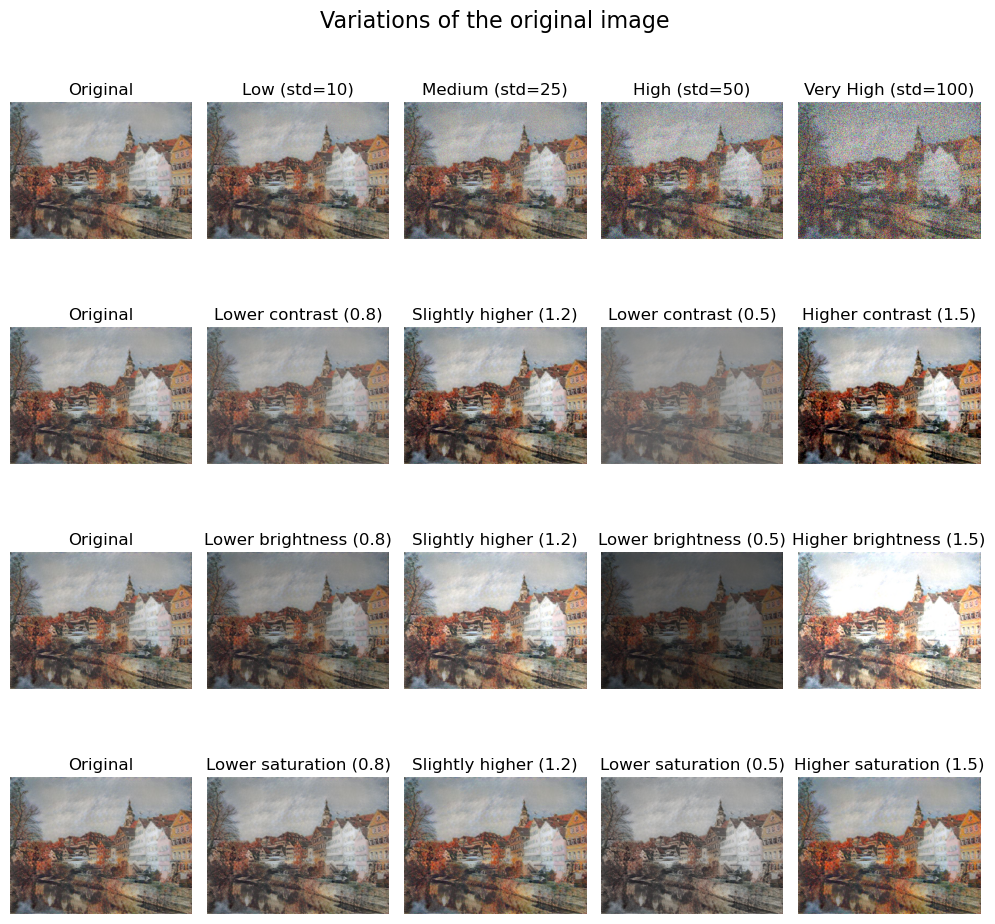

In [7]:
orig = np.array(rmse_imgs[0])
noisy_low    = add_gaussian_noise(orig, level='low')
noisy_medium = add_gaussian_noise(orig, level='medium')
noisy_high   = add_gaussian_noise(orig, level='high')
noisy_very_high = add_gaussian_noise(orig, level='very_high')

contrast_slightly_lower = generate_contrast_variation(orig, level="slightly_lower")
contrast_slightly_higher = generate_contrast_variation(orig, level="slightly_higher")
contrast_higher = generate_contrast_variation(orig, level="higher")
contrast_lower = generate_contrast_variation(orig, level="lower")

brightness_slightly_lower = generate_brightness_variation(orig, level="slightly_lower")
brightness_slightly_higher = generate_brightness_variation(orig, level="slightly_higher")
brightness_higher = generate_brightness_variation(orig, level="higher")
brightness_lower = generate_brightness_variation(orig, level="lower")

saturation_slightly_lower = generate_saturation_variation(orig, level="slightly_lower")
saturation_slightly_higher = generate_saturation_variation(orig, level="slightly_higher")
saturation_higher = generate_saturation_variation(orig, level="higher")
saturation_lower = generate_saturation_variation(orig, level="lower")

fig, axes = plt.subplots(4, 5, figsize=(10, 10))
fig.suptitle("Variations of the original image", fontsize=16)

axes[0, 0].imshow(orig);       axes[0, 0].axis('off'); axes[0, 0].set_title('Original')
axes[0, 1].imshow(noisy_low);  axes[0, 1].axis('off'); axes[0, 1].set_title(f'Low (std=10)')
axes[0, 2].imshow(noisy_medium);axes[0, 2].axis('off'); axes[0, 2].set_title(f'Medium (std=25)')
axes[0, 3].imshow(noisy_high); axes[0, 3].axis('off'); axes[0, 3].set_title(f'High (std=50)')
axes[0, 4].imshow(noisy_very_high); axes[0, 4].axis('off'); axes[0, 4].set_title(f'Very High (std=100)')

axes[1, 0].imshow(orig);       axes[1, 0].axis('off'); axes[1, 0].set_title('Original')
axes[1, 1].imshow(contrast_slightly_lower);   axes[1, 1].axis('off'); axes[1, 1].set_title('Lower contrast (0.8)')
axes[1, 2].imshow(contrast_slightly_higher); axes[1, 2].axis('off'); axes[1, 2].set_title('Slightly higher (1.2)')
axes[1, 3].imshow(contrast_lower);  axes[1, 3].axis('off'); axes[1, 3].set_title('Lower contrast (0.5)')
axes[1, 4].imshow(contrast_higher);  axes[1, 4].axis('off'); axes[1, 4].set_title('Higher contrast (1.5)')

axes[2, 0].imshow(orig);       axes[2, 0].axis('off'); axes[2, 0].set_title('Original')
axes[2, 1].imshow(brightness_slightly_lower);   axes[2, 1].axis('off'); axes[2, 1].set_title('Lower brightness (0.8)')
axes[2, 2].imshow(brightness_slightly_higher); axes[2, 2].axis('off'); axes[2, 2].set_title('Slightly higher (1.2)')
axes[2, 3].imshow(brightness_lower);  axes[2, 3].axis('off'); axes[2, 3].set_title('Lower brightness (0.5)')
axes[2, 4].imshow(brightness_higher);  axes[2, 4].axis('off'); axes[2, 4].set_title('Higher brightness (1.5)')

axes[3, 0].imshow(orig);       axes[3, 0].axis('off'); axes[3, 0].set_title('Original')
axes[3, 1].imshow(saturation_slightly_lower);   axes[3, 1].axis('off'); axes[3, 1].set_title('Lower saturation (0.8)')
axes[3, 2].imshow(saturation_slightly_higher); axes[3, 2].axis('off'); axes[3, 2].set_title('Slightly higher (1.2)')
axes[3, 3].imshow(saturation_lower);  axes[3, 3].axis('off'); axes[3, 3].set_title('Lower saturation (0.5)')
axes[3, 4].imshow(saturation_higher);  axes[3, 4].axis('off'); axes[3, 4].set_title('Higher saturation (1.5)')

plt.tight_layout()
plt.show()

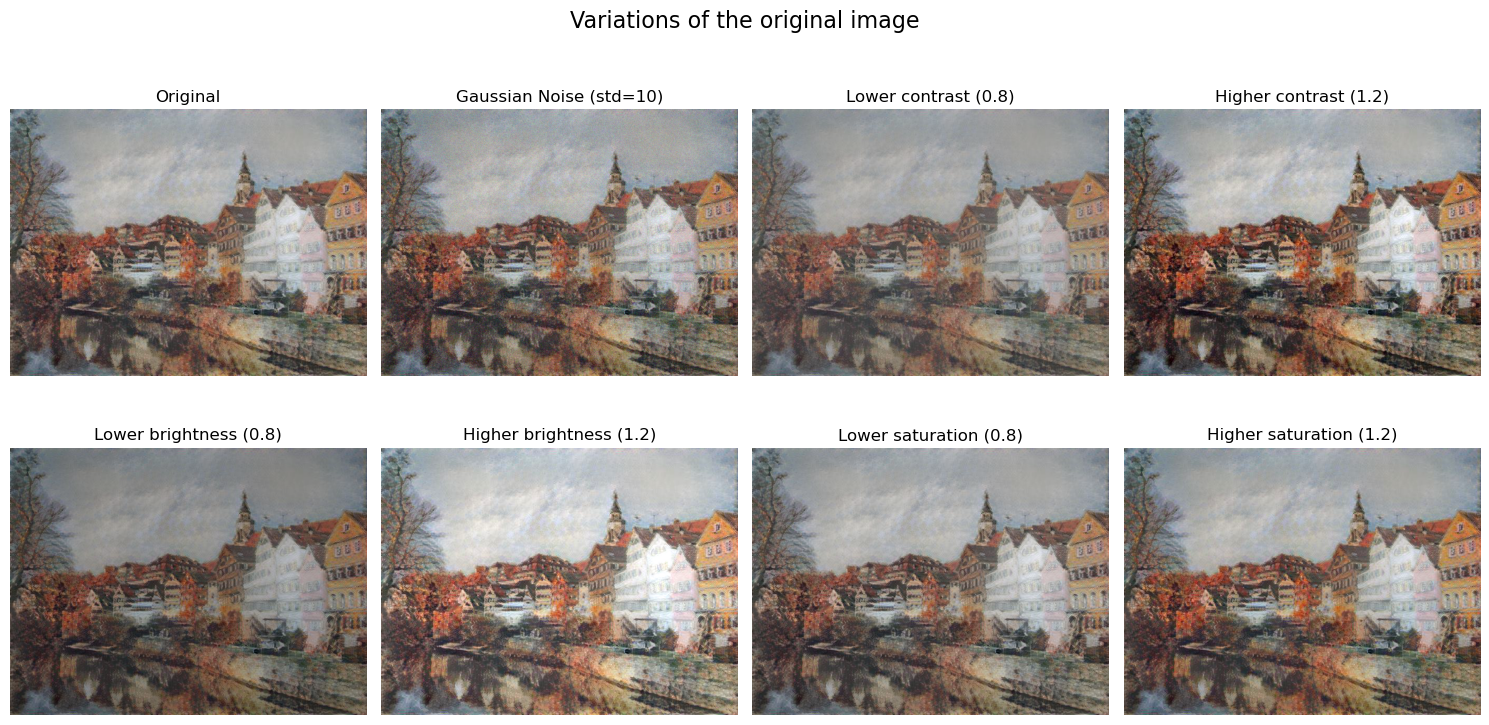

In [12]:
orig = np.array(rmse_imgs[0])
noisy_low    = add_gaussian_noise(orig, level='low')

contrast_slightly_lower = generate_contrast_variation(orig, level="slightly_lower")
contrast_slightly_higher = generate_contrast_variation(orig, level="slightly_higher")

brightness_slightly_lower = generate_brightness_variation(orig, level="slightly_lower")
brightness_slightly_higher = generate_brightness_variation(orig, level="slightly_higher")

saturation_slightly_lower = generate_saturation_variation(orig, level="slightly_lower")
saturation_slightly_higher = generate_saturation_variation(orig, level="slightly_higher")

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle("Variations of the original image", fontsize=16)

axes[0, 0].imshow(orig);       axes[0, 0].axis('off'); axes[0, 0].set_title('Original')
axes[0, 1].imshow(noisy_low);  axes[0, 1].axis('off'); axes[0, 1].set_title(f'Gaussian Noise (std=10)')
axes[0, 2].imshow(contrast_slightly_lower);   axes[0, 2].axis('off'); axes[0, 2].set_title('Lower contrast (0.8)')
axes[0, 3].imshow(contrast_slightly_higher); axes[0, 3].axis('off'); axes[0, 3].set_title('Higher contrast (1.2)')
axes[1, 0].imshow(brightness_slightly_lower);   axes[1, 0].axis('off'); axes[1, 0].set_title('Lower brightness (0.8)')
axes[1, 1].imshow(brightness_slightly_higher); axes[1, 1].axis('off'); axes[1, 1].set_title('Higher brightness (1.2)')
axes[1, 2].imshow(saturation_slightly_lower);   axes[1, 2].axis('off'); axes[1, 2].set_title('Lower saturation (0.8)')
axes[1, 3].imshow(saturation_slightly_higher); axes[1, 3].axis('off'); axes[1, 3].set_title('Higher saturation (1.2)')

plt.tight_layout()
plt.show()

## Predicting aesthetic score for Variations

In [ ]:
rmse_scores = defaultdict(list)
pearson_scores = defaultdict(list)
cosine_scores = defaultdict(list)

for idx, img in enumerate(rmse_imgs):
    variations = generate_variations(np.array(img))
    for var_type, variation in variations.items():
        image = preprocess(Image.fromarray(variation)).unsqueeze(0)
        with torch.no_grad():
            image_features = model.encode_image(image)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            prediction = amodel(image_features)
            rmse_scores[var_type].append(prediction.item())
    print(f"Processed {img.filename.rsplit('/', 1)[-1]} variations. img: {idx+1}/{len(rmse_imgs)}")

for idx, img in enumerate(prs_imgs):
    variations = generate_variations(np.array(img))
    for var_type, variation in variations.items():
        image = preprocess(Image.fromarray(variation)).unsqueeze(0)
        with torch.no_grad():
            f = model.encode_image(image)
            f /= f.norm(dim=-1, keepdim=True)
            pred = amodel(f).item()
        pearson_scores[var_type].append(pred)
    print(f"Processed {img.filename.rsplit('/', 1)[-1]} variations. img: {idx+1}/{len(prs_imgs)}")

for idx, img in enumerate(cos_imgs):
    variations = generate_variations(np.array(img))
    for var_type, variation in variations.items():
        image = preprocess(Image.fromarray(variation)).unsqueeze(0)
        with torch.no_grad():
            f = model.encode_image(image)
            f /= f.norm(dim=-1, keepdim=True)
            pred = amodel(f).item()
        cosine_scores[var_type].append(pred)
    print(f"Processed {img.filename.rsplit('/', 1)[-1]} variations. img: {idx+1}/{len(cos_imgs)}")


In [88]:
# os.makedirs('variations_LAION_scores', exist_ok=True)

# paths = {
#     'rmse': 'rmse_scores.json',
#     'pearson': 'pearson_scores.json',
#     'cosine': 'cosine_scores.json'
# }

# with open(os.path.join('variations_LAION_scores', paths['rmse']), 'w') as f:
#     json.dump(dict(rmse_scores), f, indent=4)
# with open(os.path.join('variations_LAION_scores', paths['pearson']), 'w') as f:
#     json.dump(dict(pearson_scores), f, indent=4)
# with open(os.path.join('variations_LAION_scores', paths['cosine']), 'w') as f:
#     json.dump(dict(cosine_scores), f, indent=4)

### Reading from json

In [6]:
folder = 'variations_LAION_scores'
rmse_scores = defaultdict(list)
pearson_scores = defaultdict(list)
cosine_scores = defaultdict(list)

for filename, dd in [
    ('rmse_scores.json', rmse_scores),
    ('pearson_scores.json', pearson_scores),
    ('cosine_scores.json', cosine_scores),
]:
    path = os.path.join(folder, filename)
    with open(path, 'r') as f:
        data = json.load(f)
    for k, v in data.items():
        dd[k] = v

## Showing Original Images for reference

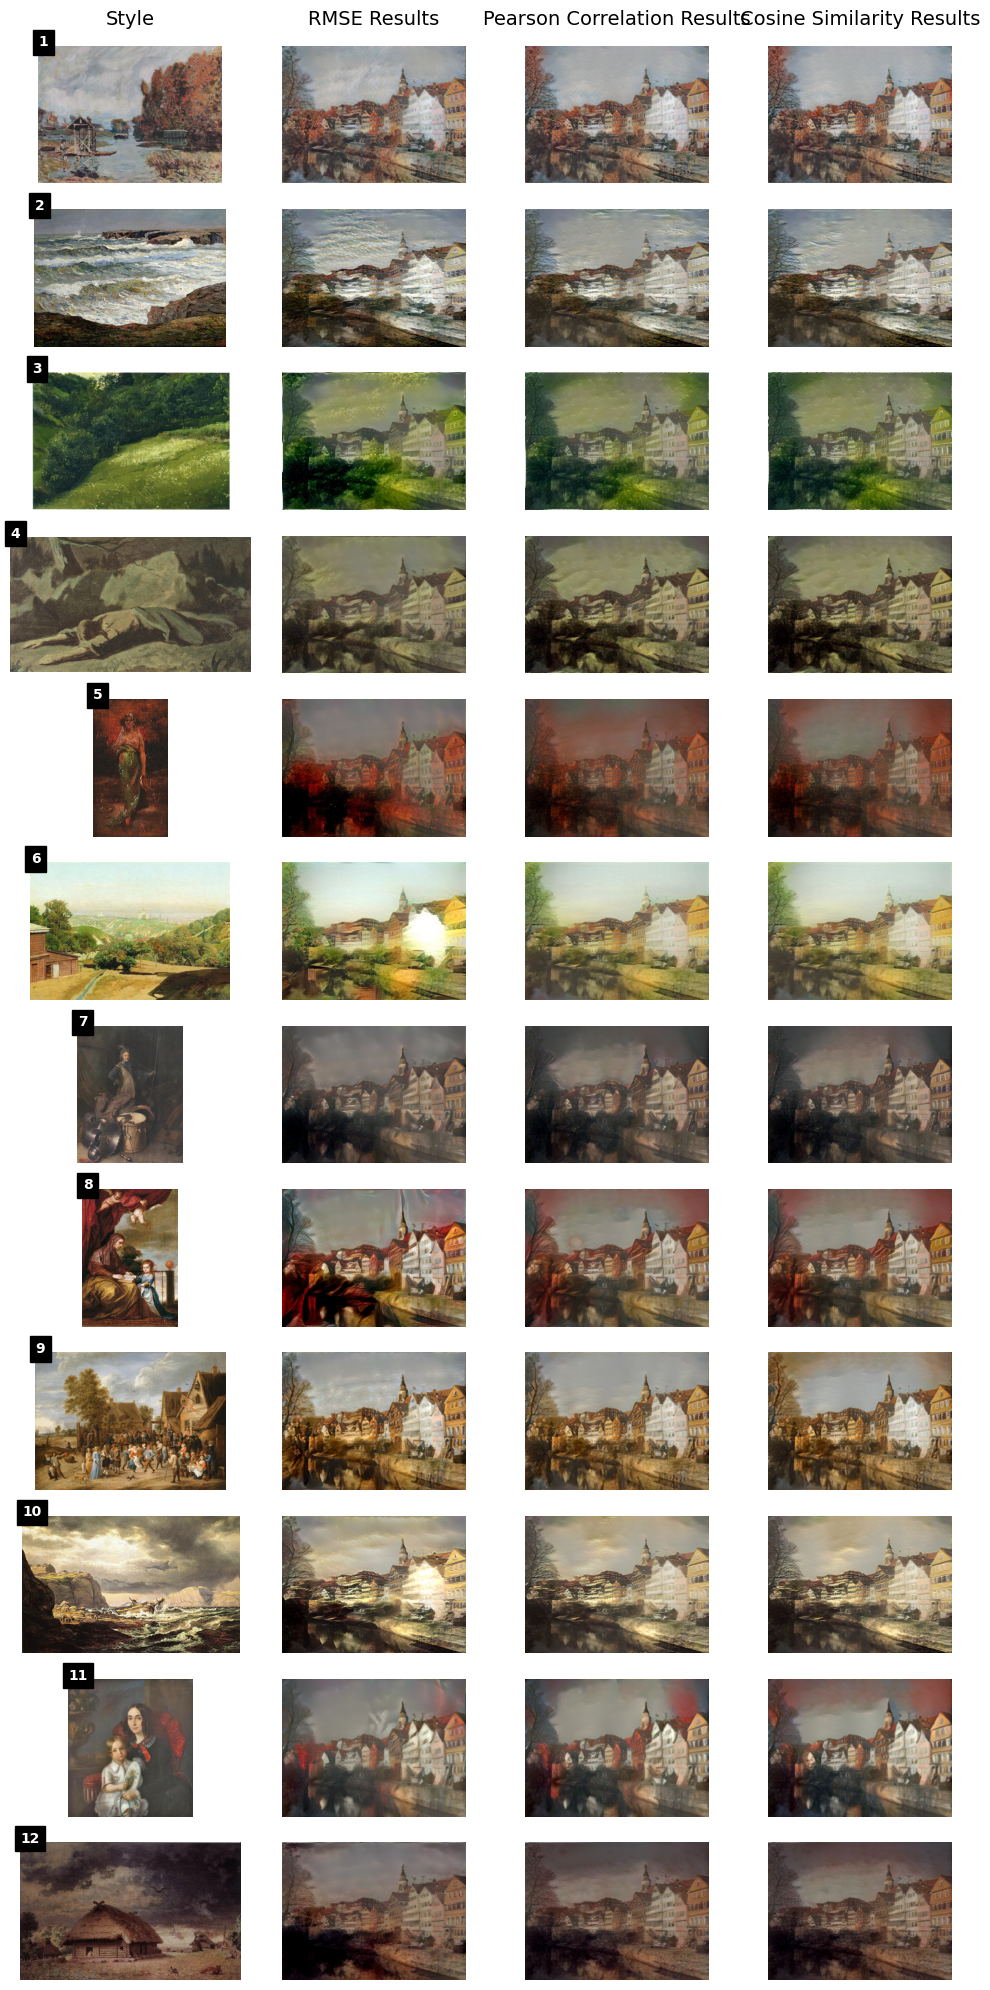

In [172]:
top4styles = ["Impressionism", "Realism", "Baroque", "Romanticism"]

image_path = Path('styles/out')
style_images = []

for style in top4styles:
    for i in range(3):
        style_images.append(Image.open(str(image_path) + "/" + f"{style}_{i}.jpg"))

root = Path("synth_out")
rmse_imgs, prs_imgs, cos_imgs = [], [], []
for style in top4styles:
    for i in range(3):
        rmse_imgs.append(Image.open(root / f"RMSE_{style}_{i}.jpg"))
        prs_imgs.append(Image.open(root / f"PRS_{style}_{i}.jpg"))
        cos_imgs.append(Image.open(root / f"COS_{style}_{i}.jpg"))
                            
fig, axes = plt.subplots(nrows=12, ncols=4, figsize=(10, 20))
col_titles = ["Style", "RMSE Results", "Pearson Correlation Results", "Cosine Similarity Results"]

# add column titles once, centered above corresponding column
for c, title in enumerate(col_titles):
    axes[0, c].set_title(title, fontsize=14, pad=15)

# zip the four lists row-wise and plot
for r, (style_im, rmse_im, prs_im, cos_im) in enumerate(
        zip(style_images, rmse_imgs, prs_imgs, cos_imgs)):
    for c, im in enumerate([style_im, rmse_im, prs_im, cos_im]):
        axes[r, c].imshow(im)
        if c == 0:
            axes[r, c].text(
                5, 5,            
                str(r+1),        
                fontsize=10,
                color='white',
                weight='bold',
                backgroundcolor='black'
            )
        axes[r, c].axis("off")


plt.tight_layout()
plt.show()

## Showing Aesthetic Score of Picture Variations
### Showing Eeach Individual Score

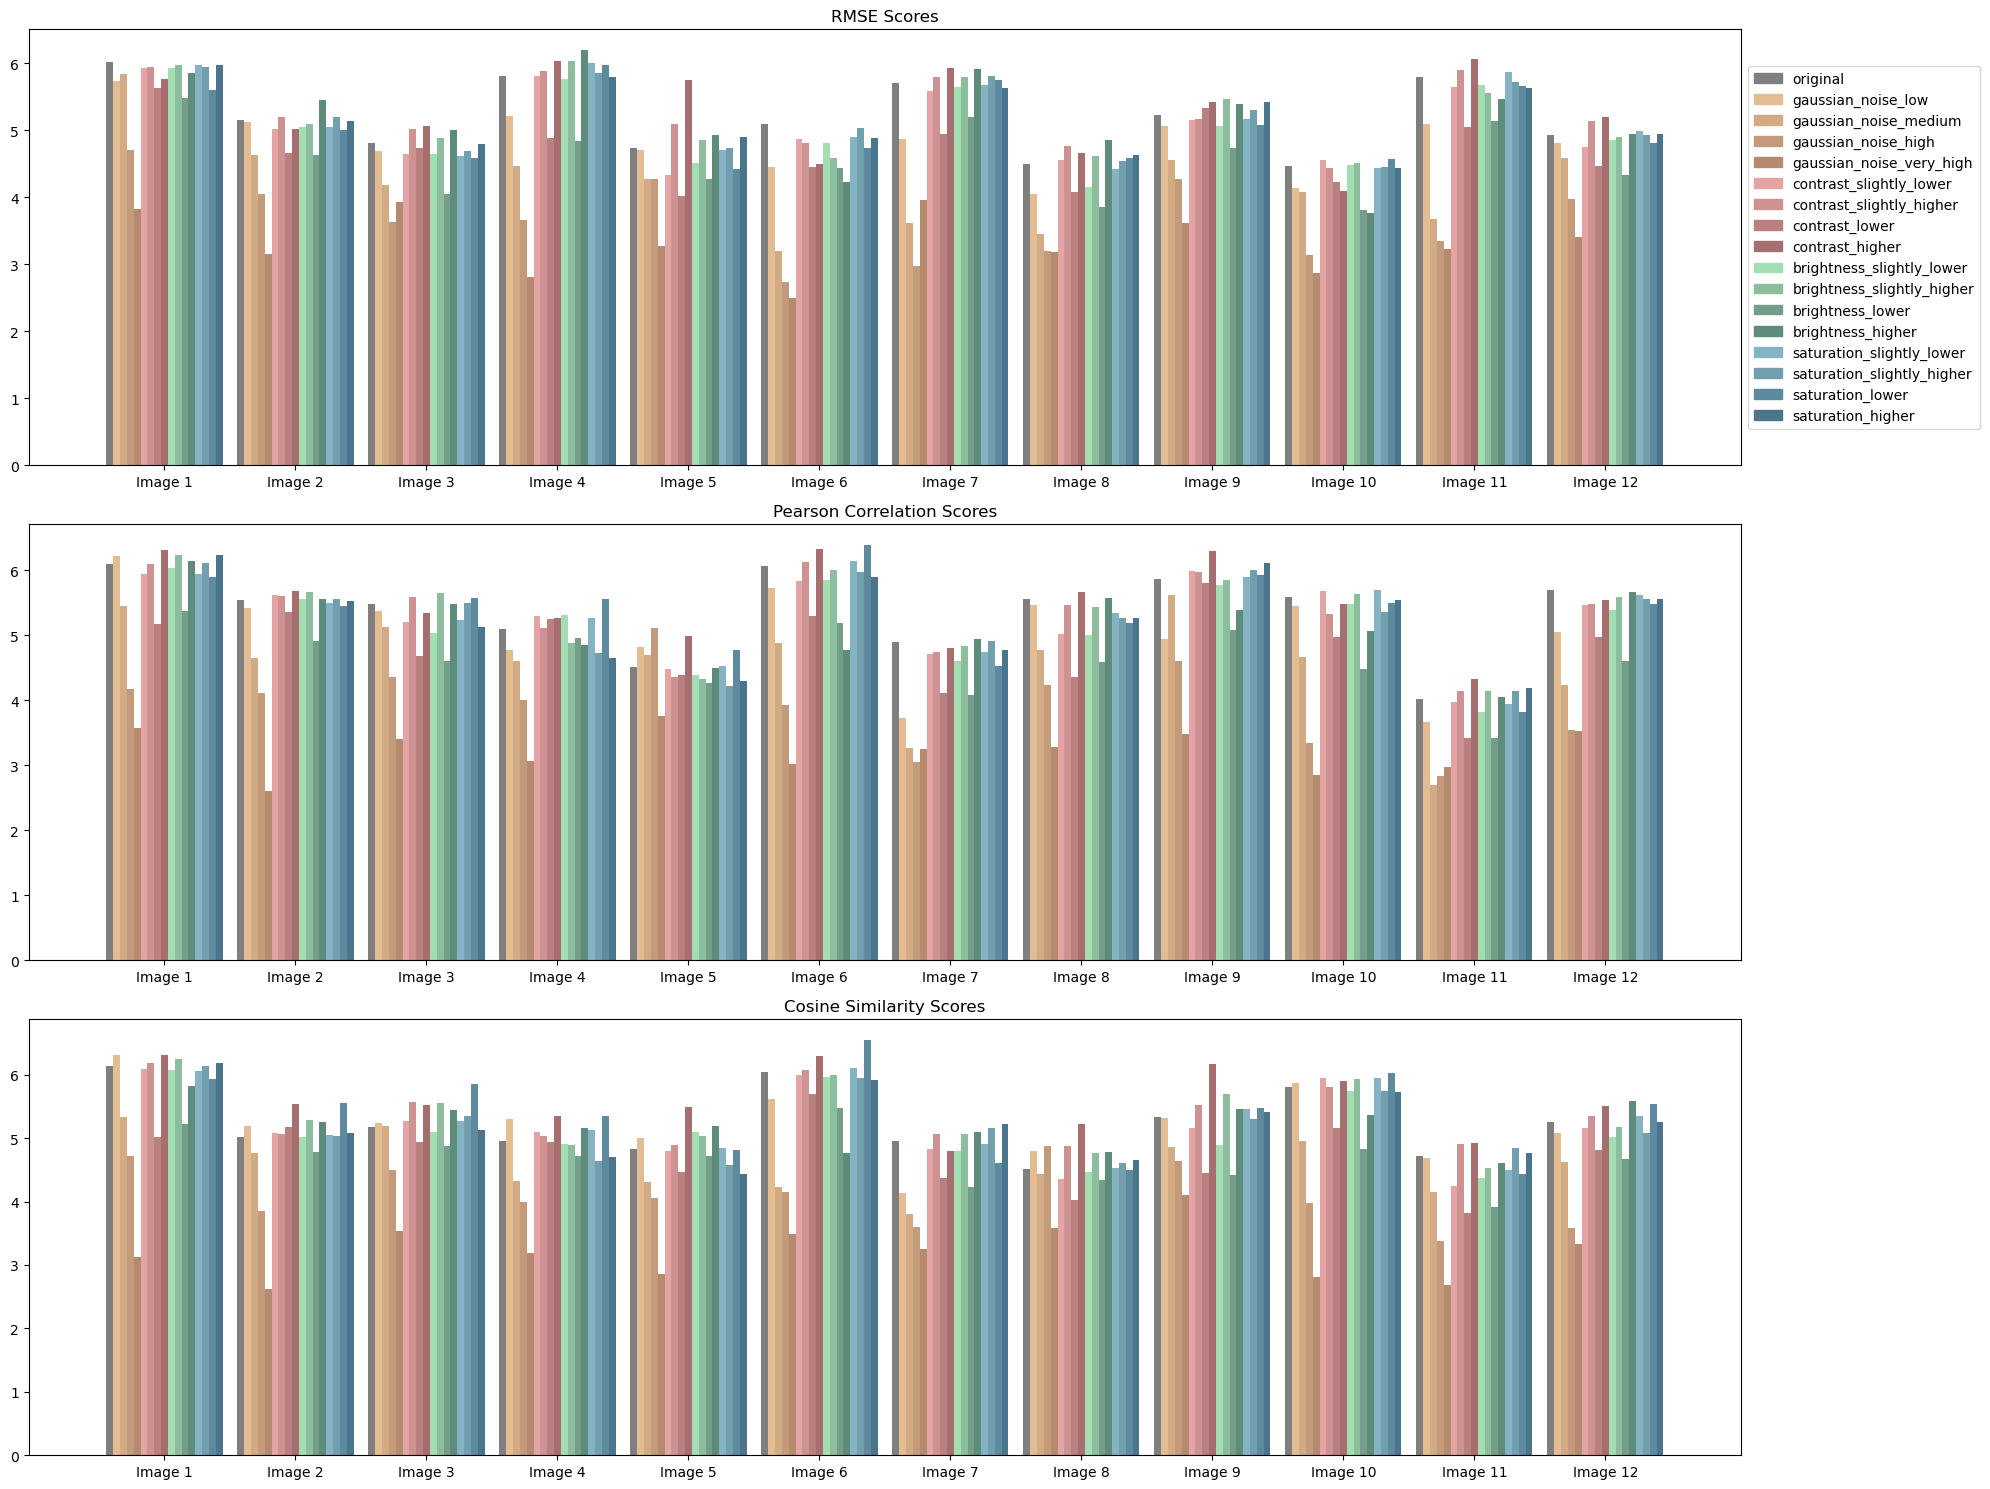

In [7]:
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
n_pictures = len(rmse_scores["original"])
w = 0.00055
base = np.arange(n_pictures) * (w + 0.01)

labels = list(rmse_scores.keys())
cmap = plt.get_cmap('tab20')
colors = [
    "#7f7f7f",
    "#e3bc91", "#d2ab85", "#c39a7a", "#b58a6e",
    "#e4a4a4", "#ce9292", "#ba8080", "#a66e6e",
    "#a3deb3", "#8cbe9e", "#759e8a", "#5e8c7a",
    "#85b3c3", "#719fae", "#5e8a9f", "#4b758c",
]
color_map = {lab: color for lab, color in zip(labels, colors)}
handles = [Patch(color=color_map[lab], label=lab) for lab in labels]

# RMSE
ax = axs[0]
ax.set_title("RMSE Scores")
for idx in range(n_pictures):
    for jdx, var_type in enumerate(rmse_scores.keys()):
        group = (jdx + 1) // 4
        ax.bar(base[idx] + jdx*w, rmse_scores[var_type][idx], width=w, tick_label=var_type, color=color_map[var_type])
ax.set_xticks(base + w * (len(rmse_scores) - 1) / 2)
ax.set_xticklabels([f"Image {i+1}" for i in range(n_pictures)])

ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

# Pearson Correlation
ax = axs[1]
ax.set_title("Pearson Correlation Scores")
for idx in range(n_pictures):
    for jdx, var_type in enumerate(pearson_scores.keys()):
        group = (jdx + 1) // 4
        ax.bar(base[idx] + jdx*w, pearson_scores[var_type][idx], width=w, tick_label=var_type, color=color_map[var_type])
ax.set_xticks(base + w * (len(pearson_scores) - 1) / 2)
ax.set_xticklabels([f"Image {i+1}" for i in range(n_pictures)])

# Cosine Similarity
ax = axs[2]
ax.set_title("Cosine Similarity Scores")
for idx in range(n_pictures):
    for jdx, var_type in enumerate(cosine_scores.keys()):
        group = (jdx + 1) // 4
        ax.bar(base[idx] + jdx*w, cosine_scores[var_type][idx], width=w, tick_label=var_type, color=color_map[var_type])
ax.set_xticks(base + w * (len(cosine_scores) - 1) / 2)
ax.set_xticklabels([f"Image {i+1}" for i in range(n_pictures)])

fig.tight_layout()
plt.show()

In [7]:
low_variations = [
    "original",
    "gaussian_noise_low",
    "contrast_slightly_lower",
    "contrast_slightly_higher",
    "brightness_slightly_lower",
    "brightness_slightly_higher",
    "saturation_slightly_lower",
    "saturation_slightly_higher",
]

new_labels = [
    "Original",
    "Gaussian Noise (std=10)",
    "Contrast Lower (0.8)",
    "Contrast Higher (1.2)",
    "Brightness Lower (0.8)",
    "Brightness Higher (1.2)",
    "Saturation Lower (0.8)",
    "Saturation Higher (1.2)",
]

rmse_scores_subset = {k: v for k, v in rmse_scores.items() if k in low_variations}
pearson_scores_subset = {k: v for k, v in pearson_scores.items() if k in low_variations}
cosine_scores_subset = {k: v for k, v in cosine_scores.items() if k in low_variations}

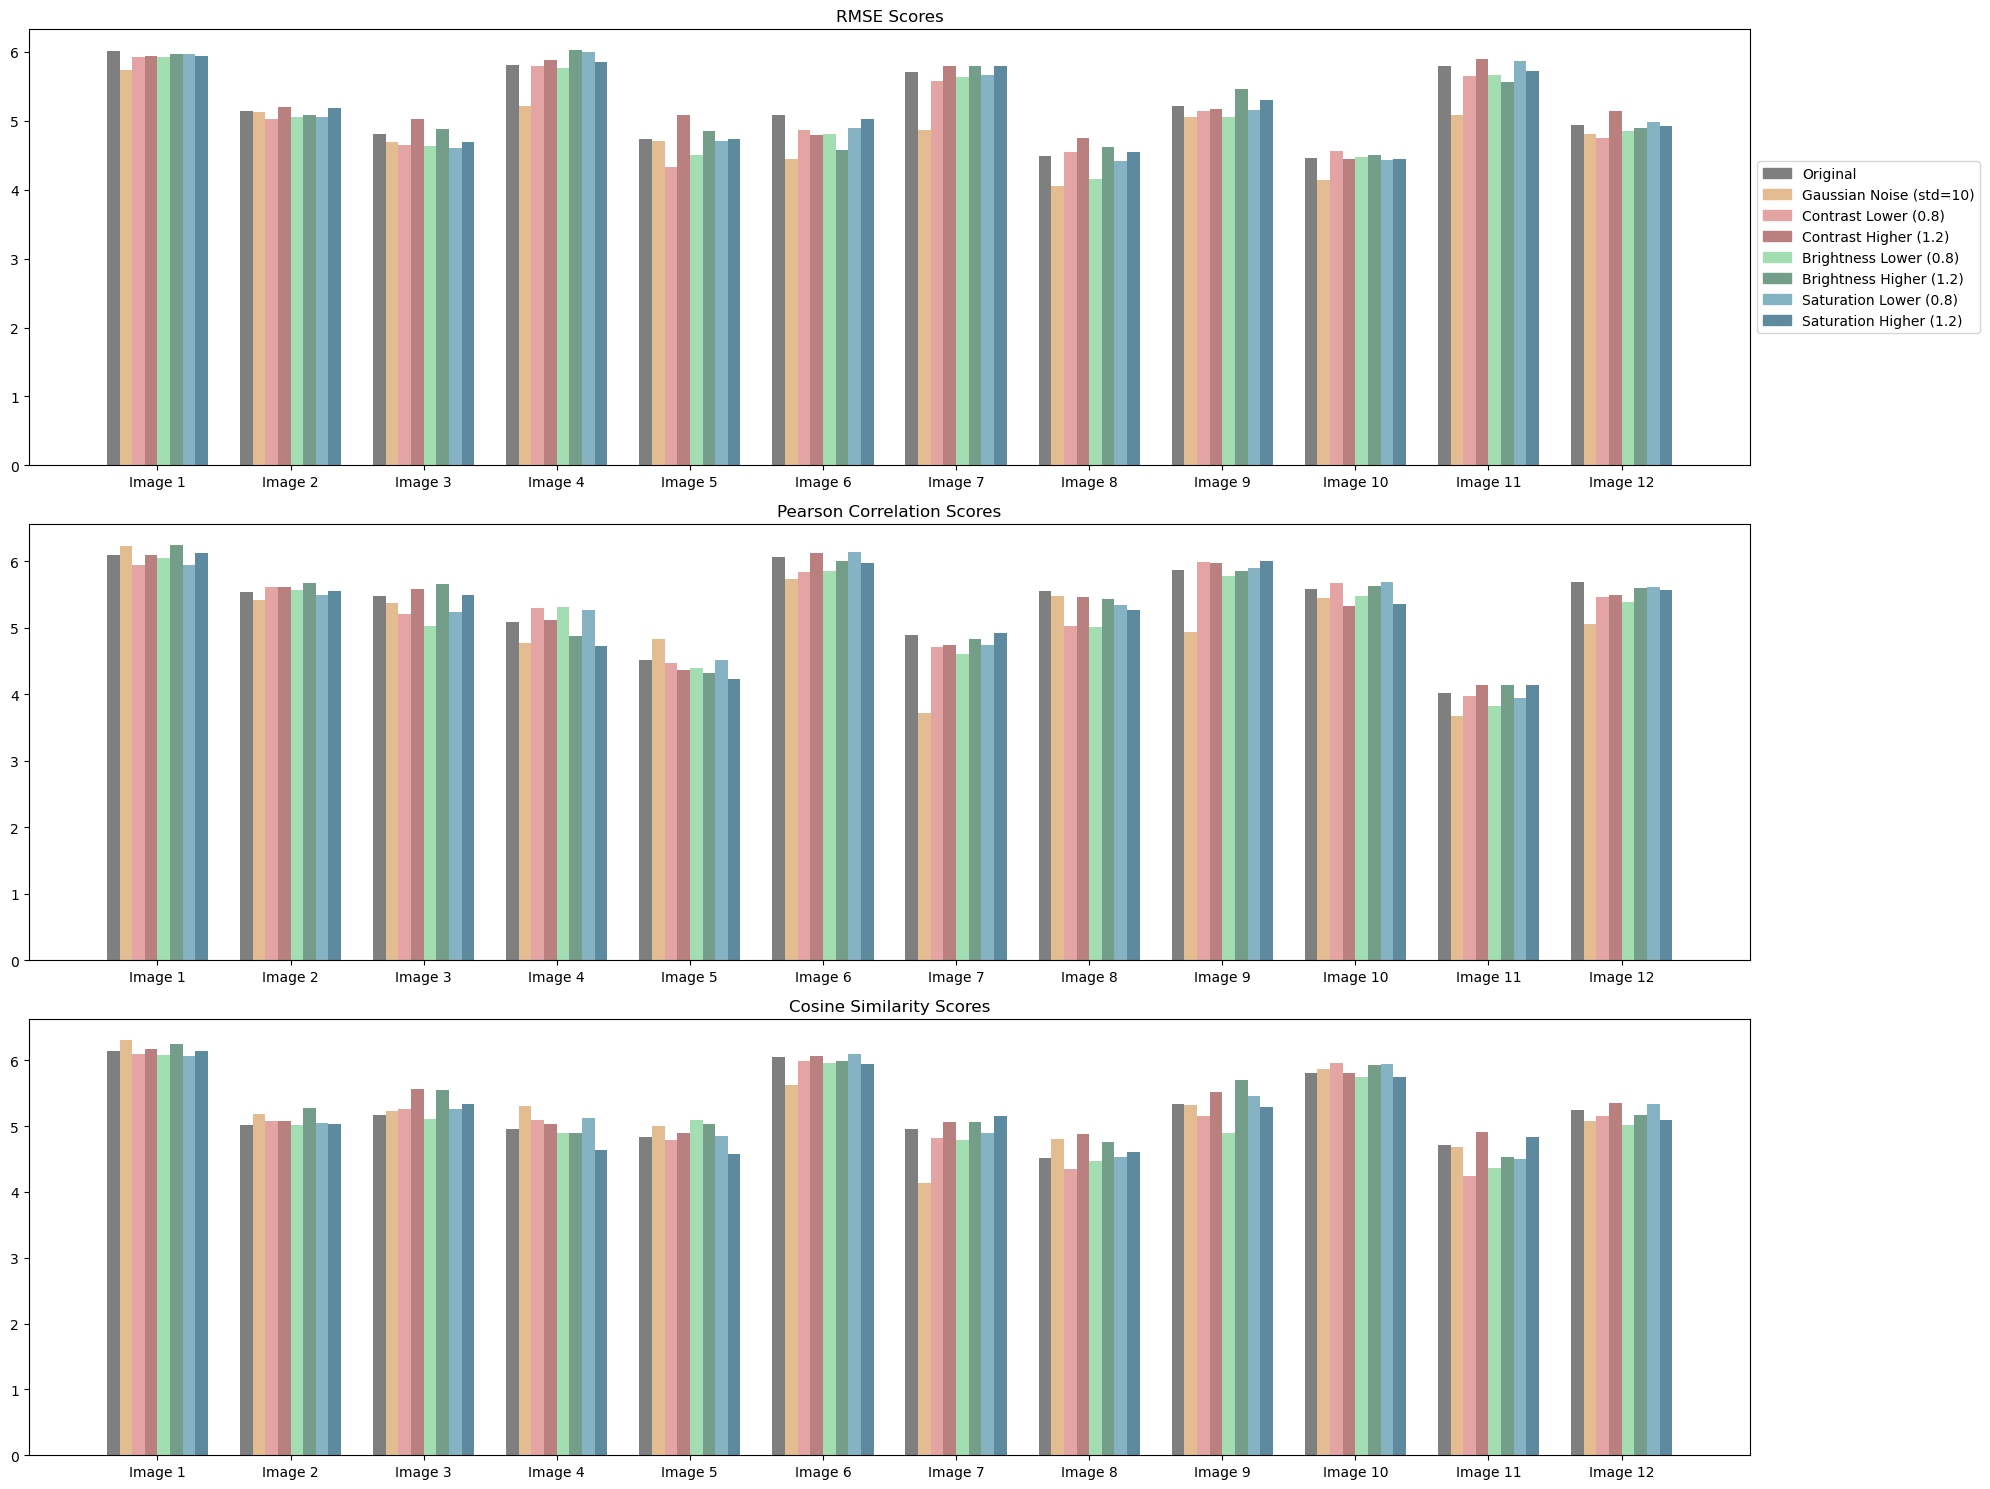

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(20, 15))
n_pictures = len(rmse_scores["original"])
w = 0.00105
base = np.arange(n_pictures) * (w + 0.01)

labels = list(rmse_scores_subset.keys())
cmap = plt.get_cmap('tab20')
colors = [
    "#7f7f7f",
    "#e3bc91",
    "#e4a4a4", "#ba8080",
    "#a3deb3", "#759e8a",
    "#85b3c3", "#5e8a9f",
]
color_map = {lab: color for lab, color in zip(labels, colors)}
handles = [Patch(color=color_map[lab], label=new_labels[idx]) for idx, lab in enumerate(labels)]

# RMSE
ax = axs[0]
ax.set_title("RMSE Scores")
for idx in range(n_pictures):
    for jdx, var_type in enumerate(rmse_scores_subset.keys()):
        group = (jdx + 1) // 4
        ax.bar(base[idx] + jdx*w, rmse_scores_subset[var_type][idx], width=w, tick_label=var_type, color=color_map[var_type])
ax.set_xticks(base + w * (len(rmse_scores_subset) - 1) / 2)
ax.set_xticklabels([f"Image {i+1}" for i in range(n_pictures)])

ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))

# Pearson Correlation
ax = axs[1]
ax.set_title("Pearson Correlation Scores")
for idx in range(n_pictures):
    for jdx, var_type in enumerate(pearson_scores_subset.keys()):
        group = (jdx + 1) // 4
        ax.bar(base[idx] + jdx*w, pearson_scores_subset[var_type][idx], width=w, tick_label=var_type, color=color_map[var_type])
ax.set_xticks(base + w * (len(pearson_scores_subset) - 1) / 2)
ax.set_xticklabels([f"Image {i+1}" for i in range(n_pictures)])

# Cosine Similarity
ax = axs[2]
ax.set_title("Cosine Similarity Scores")
for idx in range(n_pictures):
    for jdx, var_type in enumerate(cosine_scores_subset.keys()):
        group = (jdx + 1) // 4
        ax.bar(base[idx] + jdx*w, cosine_scores_subset[var_type][idx], width=w, tick_label=var_type, color=color_map[var_type])
ax.set_xticks(base + w * (len(cosine_scores_subset) - 1) / 2)
ax.set_xticklabels([f"Image {i+1}" for i in range(n_pictures)])

fig.tight_layout()
plt.show()

### Showing Variability of Each Picture (Low-level Variations)

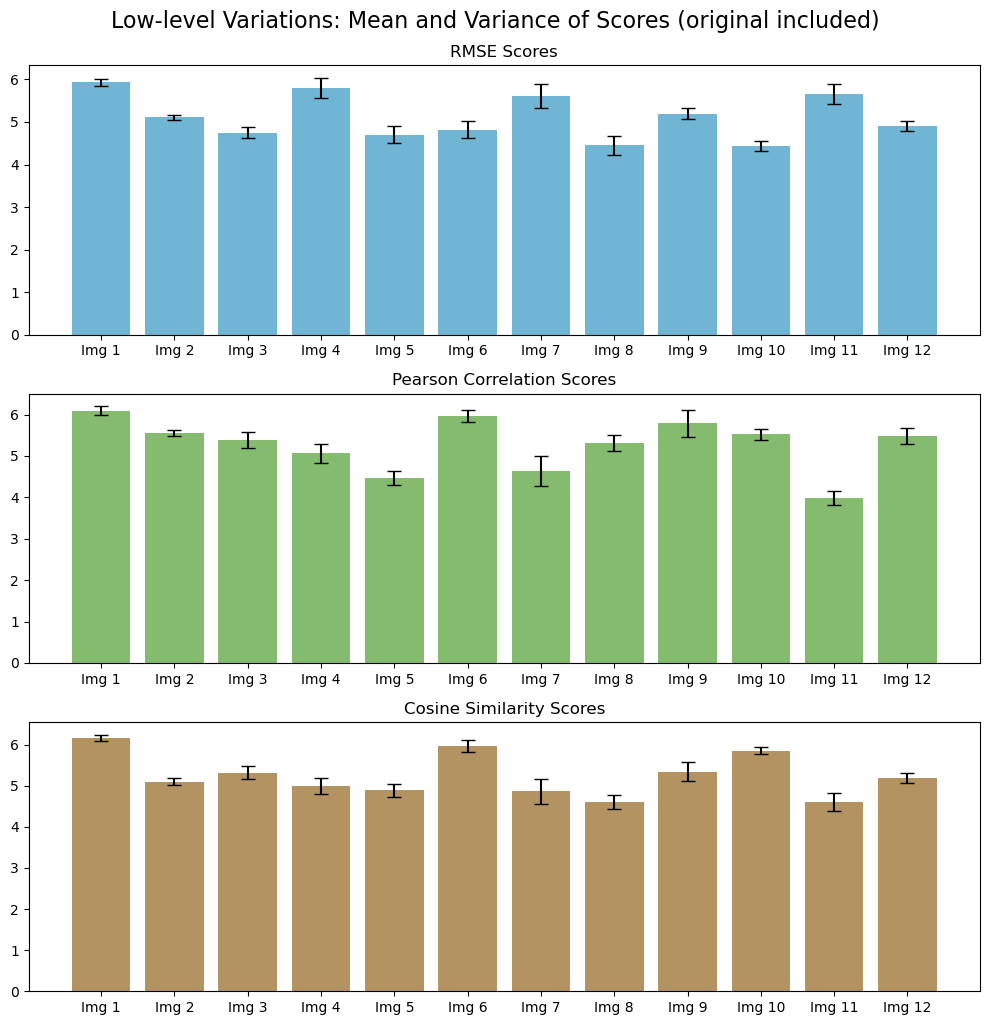

In [23]:
low_variations = [
    "original",
    "gaussian_noise_low",
    "contrast_slightly_lower",
    "contrast_slightly_higher",
    "brightness_slightly_lower",
    "brightness_slightly_higher",
    "saturation_slightly_lower",
    "saturation_slightly_higher",
]

n = len(low_variations)


fig, axs = plt.subplots(3, 1, figsize=(10, 10))


# RMSE
ax = axs[0]
ax.set_title("RMSE Scores")

for idx in range(n_pictures):

    height = np.mean([rmse_scores[var][idx] for var in low_variations])
    variance = np.std([rmse_scores[var][idx] for var in low_variations])

    ax.bar(idx, height, yerr=variance, capsize=5, color="#71b5d4")

ax.set_xticks(np.arange(n_pictures))
ax.set_xticklabels([f"Img {i+1}" for i in range(n_pictures)])

# Pearson Correlation
ax = axs[1]
ax.set_title("Pearson Correlation Scores")

for idx in range(n_pictures):

    height = np.mean([pearson_scores[var][idx] for var in low_variations])
    variance = np.std([pearson_scores[var][idx] for var in low_variations])

    ax.bar(idx, height, yerr=variance, capsize=5, color="#85bb6e")

ax.set_xticks(np.arange(n_pictures))
ax.set_xticklabels([f"Img {i+1}" for i in range(n_pictures)])
# Cosine Similarity
ax = axs[2]
ax.set_title("Cosine Similarity Scores")

for idx in range(n_pictures):

    height = np.mean([cosine_scores[var][idx] for var in low_variations])
    variance = np.std([cosine_scores[var][idx] for var in low_variations])

    ax.bar(idx, height, yerr=variance, capsize=5, color="#b29361")

ax.set_xticks(np.arange(n_pictures))
ax.set_xticklabels([f"Img {i+1}" for i in range(n_pictures)])

fig.tight_layout()
fig.suptitle("Low-level Variations: Mean and Variance of Scores (original included)", fontsize=16, y=1.02)
plt.show()

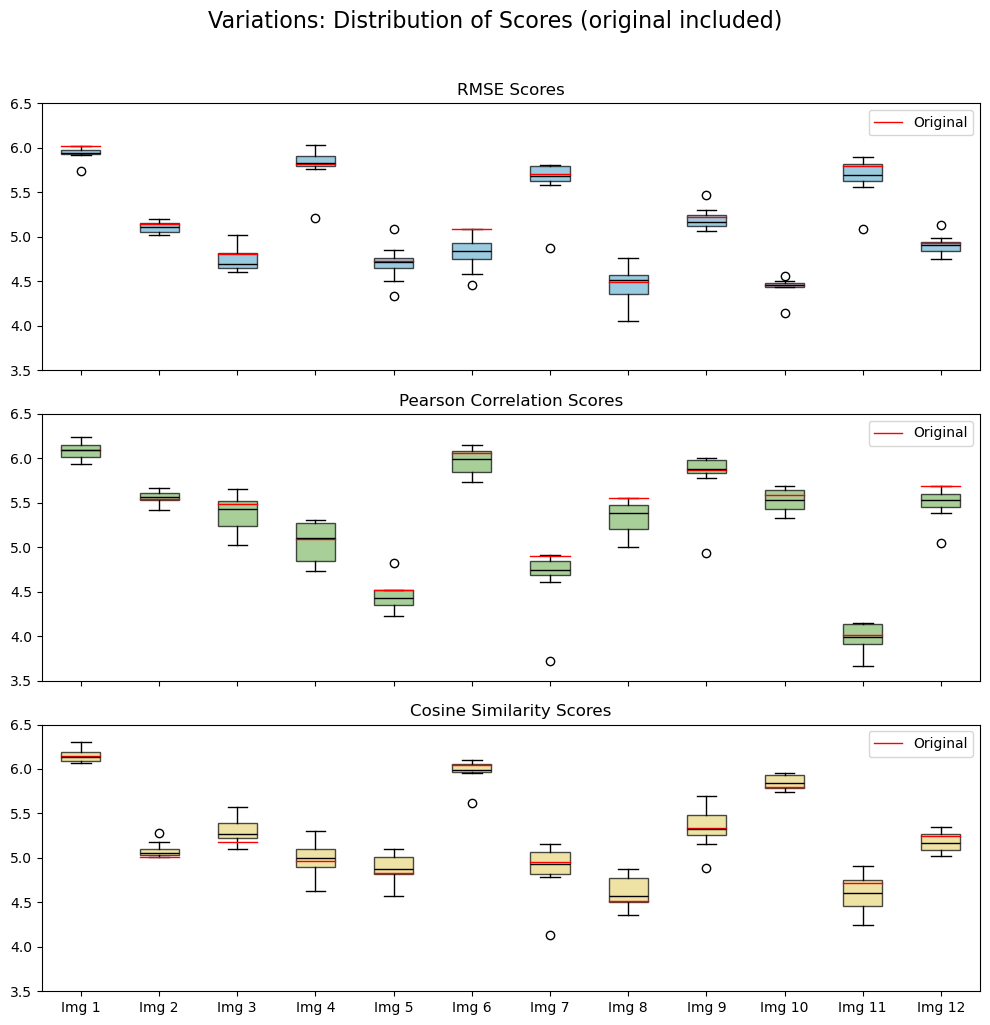

In [47]:
fig, axs = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

metrics = [
    ("RMSE Scores", rmse_scores, "#71b5d4"),
    ("Pearson Correlation Scores", pearson_scores, "#85bb6e"),
    ("Cosine Similarity Scores", cosine_scores, "#e7d87f"),
]

for ax, (title, scores_dict, color) in zip(axs, metrics):
    ax.set_title(title)
    
    # Collect per‑image scores across all low-level variations
    data = [[scores_dict[var][idx] for var in low_variations]
            for idx in range(n_pictures)]
    
    bp = ax.boxplot(data, patch_artist=True)
    
    # Color the boxes
    for box in bp['boxes']:
        box.set_facecolor(color)
        box.set_alpha(0.7)
    for median in bp['medians']:
        median.set_color('black')
    
    # Overlay original as a "median-like" tick
    original_values = [scores_dict["original"][idx] for idx in range(n_pictures)]
    for x, orig in enumerate(original_values, start=1):
        ax.plot([x - 0.25, x + 0.25], [orig, orig], color='red', linewidth=1)

    # Legend entry for original
    ax.plot([], [], color='red', linewidth=1, label='Original')
    ax.legend()

    ax.set_xticks(range(1, n_pictures + 1))
    ax.set_xticklabels([f"Img {i+1}" for i in range(n_pictures)])
    ax.set_ylim(3.5,6.5)

fig.suptitle("Variations: Distribution of Scores (original included)", fontsize=16, y=1.02)
fig.tight_layout()
plt.show()


# Score prediction on All Original Synthetic Images

In [49]:
root = Path("synth_out")
top4styles = ["Impressionism", "Realism", "Baroque", "Romanticism"]
n_per_style = 6  # change if different

def load_imgs(prefix):
    out = []
    for style in top4styles:
        for i in range(n_per_style):
            p = root / f"{prefix}_{style}_{i}.jpg"
            if not p.is_file():
                raise FileNotFoundError(p)
            out.append(Image.open(p).convert("RGB"))
    return out

rmse_imgs = load_imgs("RMSE")
prs_imgs  = load_imgs("PRS")
cos_imgs  = load_imgs("COS")


In [50]:
rmse_scores_original = []
pearson_scores_original = []
cosine_scores_original = []

for img in rmse_imgs:
    image = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        f = model.encode_image(image)
        f /= f.norm(dim=-1, keepdim=True)
        pred = amodel(f).item()
    rmse_scores_original.append(pred)

for img in prs_imgs:
    image = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        f = model.encode_image(image)
        f /= f.norm(dim=-1, keepdim=True)
        pred = amodel(f).item()
    pearson_scores_original.append(pred)

for img in cos_imgs:
    image = preprocess(img).unsqueeze(0)
    with torch.no_grad():
        f = model.encode_image(image)
        f /= f.norm(dim=-1, keepdim=True)
        pred = amodel(f).item()
    cosine_scores_original.append(pred)

## Results
### Complete + Grouped by Loss

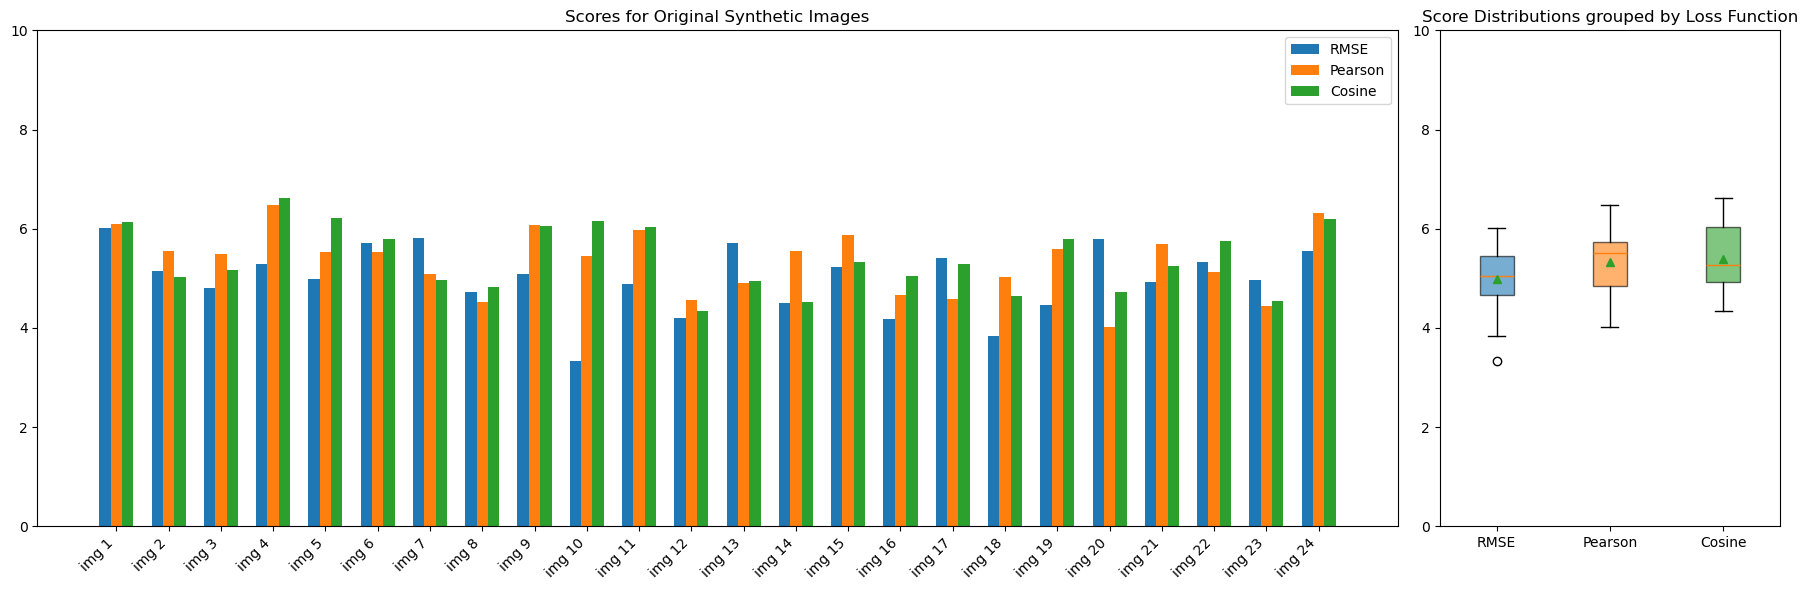

In [55]:
n = len(rmse_scores_original)
w = 0.25
base = np.arange(n) * (3*w + 0.4)

fig, (ax1, ax2) = plt.subplots(
    1, 2, figsize=(18, 6),
    gridspec_kw={'width_ratios': [4, 1]}
)

ax1.bar(base - w, rmse_scores_original,   w, color='C0', label='RMSE')
ax1.bar(base,     pearson_scores_original, w, color='C1', label='Pearson')
ax1.bar(base + w, cosine_scores_original, w, color='C2', label='Cosine')
ax1.set_xticks(base)
ax1.set_xticklabels([f'img {i+1}' for i in range(n)], rotation=45, ha='right')
ax1.set_ylim(0, 10)
ax1.set_title('Scores for Original Synthetic Images')
ax1.legend()

data = [rmse_scores_original, pearson_scores_original, cosine_scores_original]
box = ax2.boxplot(
    data,
    labels=['RMSE', 'Pearson', 'Cosine'],
    patch_artist=True,
    showmeans=True
)

# Optional: color the boxes to match the left subplot
colors = ['C0', 'C1', 'C2']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.set_ylim(0, 10)
ax2.set_title('Score Distributions grouped by Loss Function')

fig.tight_layout()
plt.show()


### Grouped by Image

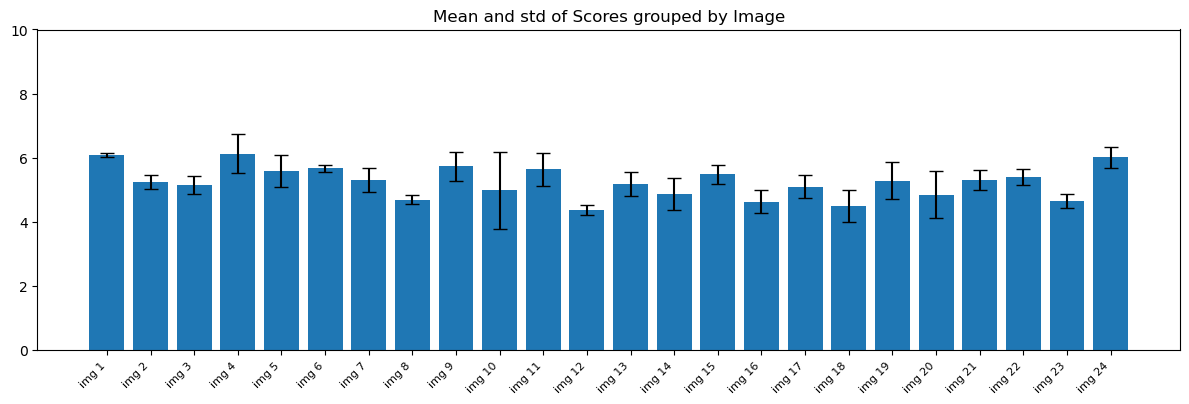

In [56]:
group_vals  = np.vstack([rmse_scores_original,
                         pearson_scores_original,
                         cosine_scores_original])
group_means = group_vals.mean(axis=0)
group_stds  = group_vals.std(axis=0)

x = np.arange(len(group_means))
plt.figure(figsize=(12, 4))
plt.bar(x, group_means, yerr=group_stds, capsize=5)
plt.xticks(x, [f'img {i+1}' for i in range(len(group_means))], rotation=45, ha='right', fontsize=8)
plt.ylim(0, 10)
plt.tight_layout()
plt.title('Mean and std of Scores grouped by Image')
plt.show()


# Statistical Test of the results

In [57]:
methods = [rmse_scores_original, pearson_scores_original, cosine_scores_original]
labels  = ['RMSE', 'Pearson', 'Cosine']

items = list(zip(labels, methods))

results = []
for (label1, m1), (label2, m2) in combinations(items, 2):
    stat, p = wilcoxon(m1, m2)
    d = np.asarray(m1) - np.asarray(m2)
    d = d[d != 0] 
    ranks = rankdata(np.abs(d), method='average')
    Wp = ranks[d > 0].sum()
    Wm = ranks[d < 0].sum()
    r_rb = (Wp - Wm) / ranks.sum()

    results.append((label1, label2, stat, p, r_rb))

print("Mean ± SD per metodo:")
for label, m in zip(labels, methods):
    mean = np.mean(m)
    sd   = np.std(m, ddof=1)
    print(f"  {label}: {mean:.3f} ± {sd:.3f}")
print()

print("Statistical Test Results:")
for (label1, label2, stat, p, r_rb) in results:
    print(f"Comparison between {label1} and {label2}:")
    print(f"  Statistic: {stat}, p-value: {p}, r_rank-biserial: {r_rb:.3f}")
    if p < 0.05:
        print("  Significant difference detected.")
    else:
        print("  No significant difference detected.")
    print()


Mean ± SD per metodo:
  RMSE: 4.994 ± 0.668
  Pearson: 5.337 ± 0.648
  Cosine: 5.389 ± 0.655

Statistical Test Results:
Comparison between RMSE and Pearson:
  Statistic: 83.0, p-value: 0.05642664432525635, r_rank-biserial: -0.447
  No significant difference detected.

Comparison between RMSE and Cosine:
  Statistic: 73.0, p-value: 0.026927709579467773, r_rank-biserial: -0.513
  Significant difference detected.

Comparison between Pearson and Cosine:
  Statistic: 125.0, p-value: 0.49079859256744385, r_rank-biserial: -0.167
  No significant difference detected.



## 